# 0.0 Imports

In [1]:
# Imports
import math
import numpy      as np
import pandas     as pd
import statistics as st
import random     as rnd
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 22
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# Load
df_sales_raw = pd.read_csv('train.csv', sep=',', low_memory=False)
df_store_raw = pd.read_csv('store.csv', sep=',', low_memory=False)

In [5]:
# Merge and View
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


# 1.0 Data Description

### Understanding Variables
**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**State Holiday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public 
holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**School Holiday** - indicates if the (Store, Date) was affected by the closure of public schools

**Store Type** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**Competition Distance** - distance in meters to the nearest competitor store

**Competition Open Since Month / Year** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo 2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo 2 Since Year / Week** - describes the year and calendar week when the store started participating in Promo2

**Promo Interval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round 
starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns 

In [6]:
# Copy the data to avoid future problems in the original data
df1 = df_raw.copy()

In [7]:
# Original Columns
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
# Transform into Snake Case
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval' ]

snakecase = lambda x: inflection.underscore (x)
cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [9]:
# Number of Rows and Columns
print('Number of Rows:', df1.shape[0])
print('Number of Columns:', df1.shape[1])


Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [10]:
# Variable Types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# Date column to date format
df1 ['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 NA´s Check 

In [12]:
# Check all NA´s
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill out NA´s

In [13]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1014567.0,5430.085652,7715.323700,20.0,710.0,2330.0,6890.0,75860.0
competition_open_since_month,693861.0,7.222866,3.211832,1.0,4.0,8.0,10.0,12.0
competition_open_since_year,693861.0,2008.690228,5.992644,1900.0,2006.0,2010.0,2013.0,2015.0


In [14]:
# Assuming NA´s in competition_distance are stores too far away (200.000,00) - Business Question
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# Assuming NA´s in competition_open_since_month can be the same as the date of the date column (future review CRISP-DS)    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# Assuming NA´s in competition_open_since_year can be the same as the date of the date column and higher than 2000 (future review CRISP-DS)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
df1['competition_open_since_year'] = df1['competition_open_since_year'].apply(lambda x: 2000.0 if x < 2000.0 else x)

# Assuming NA´s in promo2_since_week can be the same as the date of the date column (future review CRISP-DS)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# Assuming NA´s in promo2_since_year can be the same as the date of the date column (future review CRISP-DS)                
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# Assuming NA´s in promo_interval can be compared to a list and then substitute them for 0 or 1
# List to compare
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }

# Fill NA´s with 0
df1['promo_interval'].fillna(0, inplace=True)

# Creating a new column month_map maping with date column and the list month_map (numbers will be subtitute for strings)                         
df1['month_map'] = df1['date'].dt.month.map(month_map)
                                    
# Creating a new column is_promo comparing promo_interval with month_map and returnig 0 or 1    
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)                                     

In [15]:
# Sample
df1.sample(5).T

,385834,877412,659602,331768,159125
store,947,693,308,21,796
day_of_week,5,1,7,6,3
date,2014-07-25 00:00:00,2013-05-06 00:00:00,2013-11-17 00:00:00,2014-09-20 00:00:00,2015-03-11 00:00:00
sales,6281,5138,0,4953,6428
customers,965,428,0,544,651
open,1,1,0,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,c,a


In [16]:
# Verification
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
# Competition and promo2 as interger
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype ( int ) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype ( int ) 
df1['promo2_since_week'] = df1['promo2_since_week'].astype ( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype ( int )

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [20]:
# Numerical and Categorical Attributes
num_var = df1.select_dtypes( include = ['int64', 'float64'])
cat_var = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, meadian 
ct1 = pd.DataFrame( num_var.apply( np.mean) ).T
ct2 = pd.DataFrame( num_var.apply( np.median) ).T
ct3 = pd.DataFrame( num_var.apply( st.mode ) ).T 

# Dispersion
d1 = pd.DataFrame( num_var.apply( np.std) ).T
d2 = pd.DataFrame( num_var.apply( min) ).T
d3 = pd.DataFrame( num_var.apply( max) ).T
d4 = pd.DataFrame( num_var.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_var.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_var.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4, d5, d6 ]).T.reset_index()
ds.columns = ['attributes', 'mean', 'median', 'mode', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
ds

,attributes,mean,median,mode,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,1.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,5.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,0.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,250.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,promo2,0.500564,1.0,1.0,0.500000,0.0,1.0,1.0,-0.002255,-1.999999
9,is_promo,0.165966,0.0,0.0,0.372050,0.0,1.0,1.0,1.795644,1.224338


### 1.7.2 Categorial Attributes

In [22]:
# Values of categorical
cat_var.apply( lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     16
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

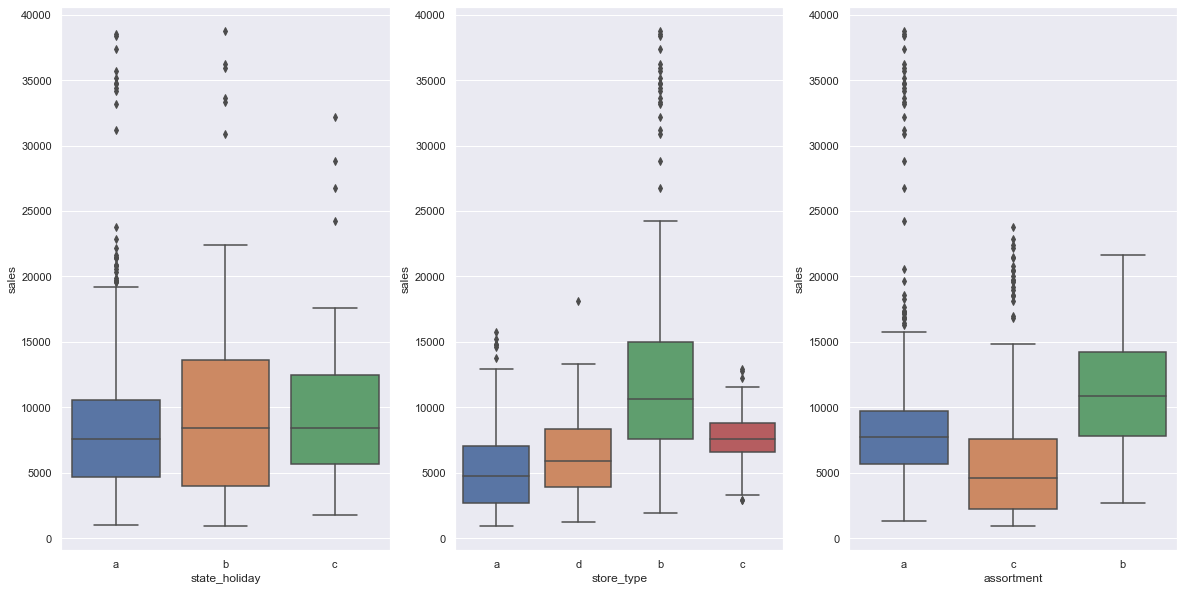

In [23]:
# Boxplot's of state holidays, store types and assortment types by sales
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

#  2.0 Feature Engineering

## 2.1 Hyphotesis Mental Map

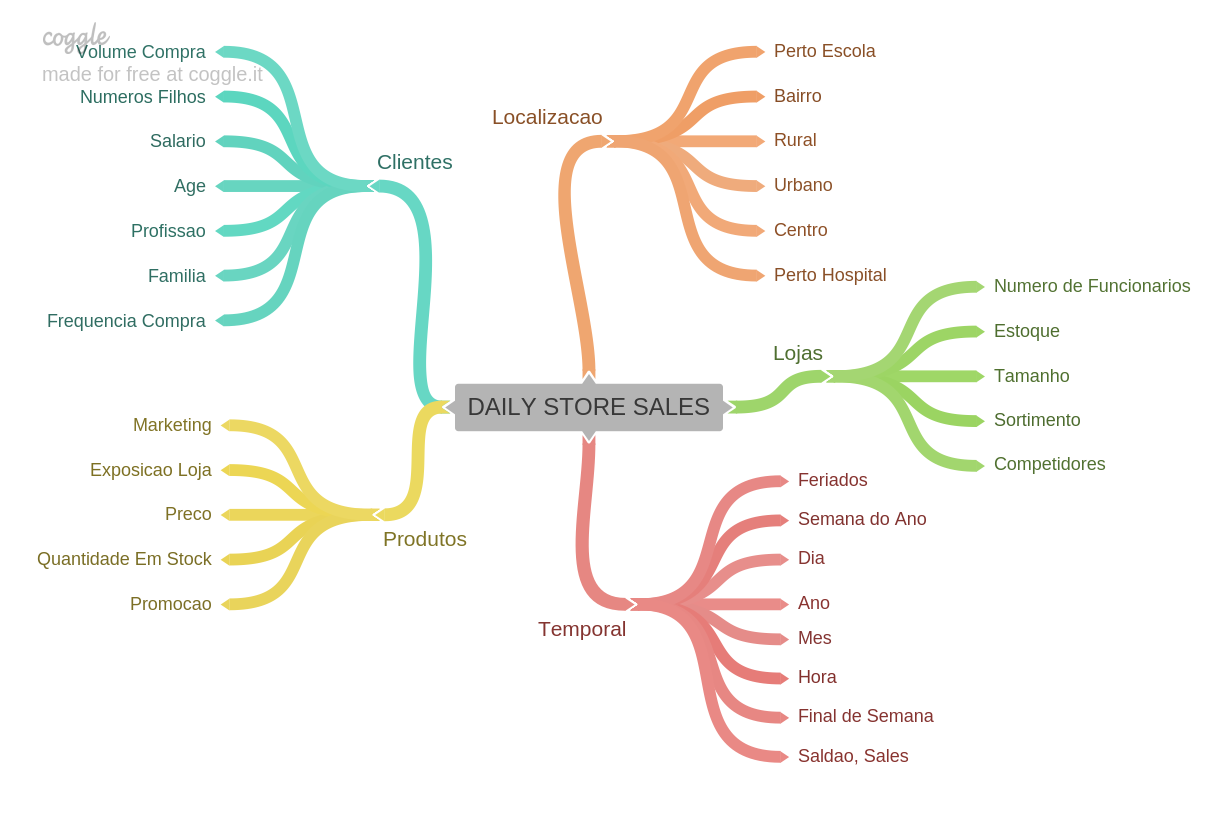

In [24]:
Image( 'img/MindMapHypothesis.png' )

In [25]:
df2 = df1.copy() 

## 2.2 Hypothesis List

**1.** Stores with higher assortments should sell more.

**2.** Stores with closer competitors should sell less 

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions should sell more.

**5.** Stores with more consecutive promotions should sell more.

**6.** Stores open during the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell less on weekends.

**10.** Stores should sell less during school holidays.

## 2.3 Feature Engineering

In [26]:
# year
df2[ 'year' ] = df2[ 'date' ].dt.year

# month
df2[ 'month' ] = df2[ 'date' ].dt.month

# day
df2[ 'day' ] = df2[ 'date' ].dt.day

# week of year
df2[ 'week_of_year' ] = df2[ 'date' ].dt.weekofyear

# year week
df2[ 'year_week' ] = df2[ 'date' ].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime( year=x[ 'competition_open_since_year' ], month=x[ 'competition_open_since_month' ],day=1 ), axis=1 )

df2[ 'competition_time_month' ] = ( ( df2[ 'date' ] - df2[ 'competition_since' ] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2[ 'promo_since' ] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2[ 'promo2_since_week' ].astype( str )

df2[ 'promo_since' ] = df2[ 'promo_since' ].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2[ 'promo_time_week' ] = ( ( df2[ 'date' ] - df2[ 'promo_since' ] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2[ 'assortment' ] = df2[ 'assortment' ].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2[ 'state_holiday' ] = df2[ 'state_holiday' ].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Selection

In [28]:
df3 = df2.copy()

## 3.1 Line Filtering

In [29]:
# The stores should be open and sales should be higher than 0
df3 = df3[ ( df3[ 'open' ] != 0 ) & ( df3[ 'sales' ] >0 ) ]

## 3.2 Column Filtering

In [30]:
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Exploratory Data Analysis (EDA)

## 4.1 Univariate Analysis

### 4.1.1 Resposnse Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

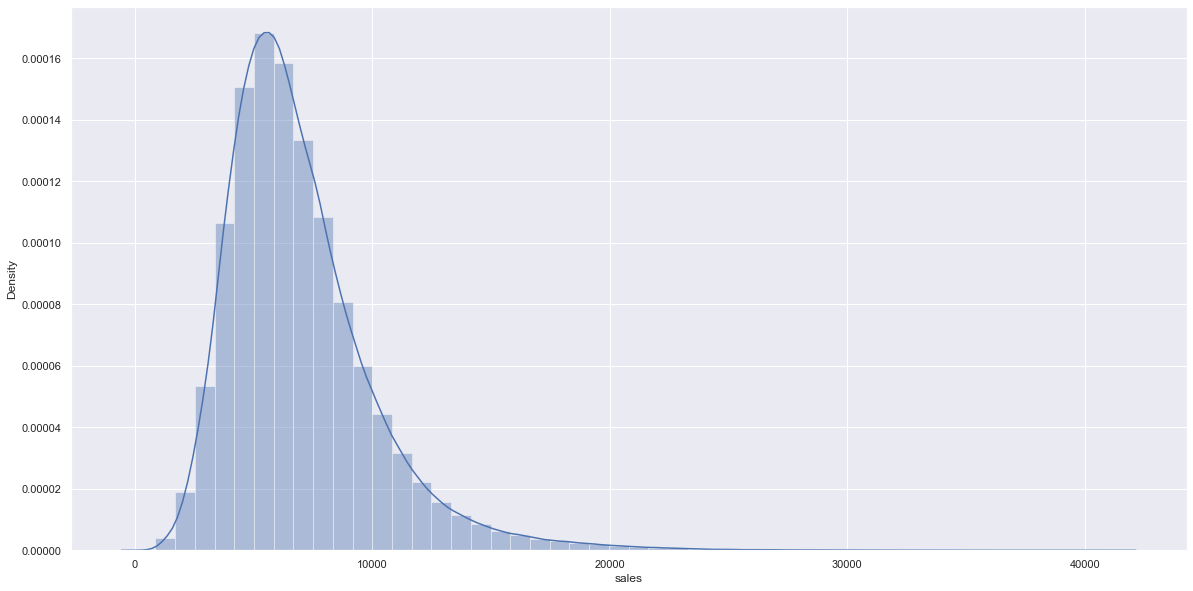

In [31]:
# Checking sales normality (response variable)
df4 = df3.copy()
sns.distplot( df4 [ 'sales' ] )

### 4.1.2 Numerical Variables

In [32]:
# Update Numerical and Categorical Variables
num_var = df4.select_dtypes( include = ['int64', 'float64'])
cat_var = df4.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

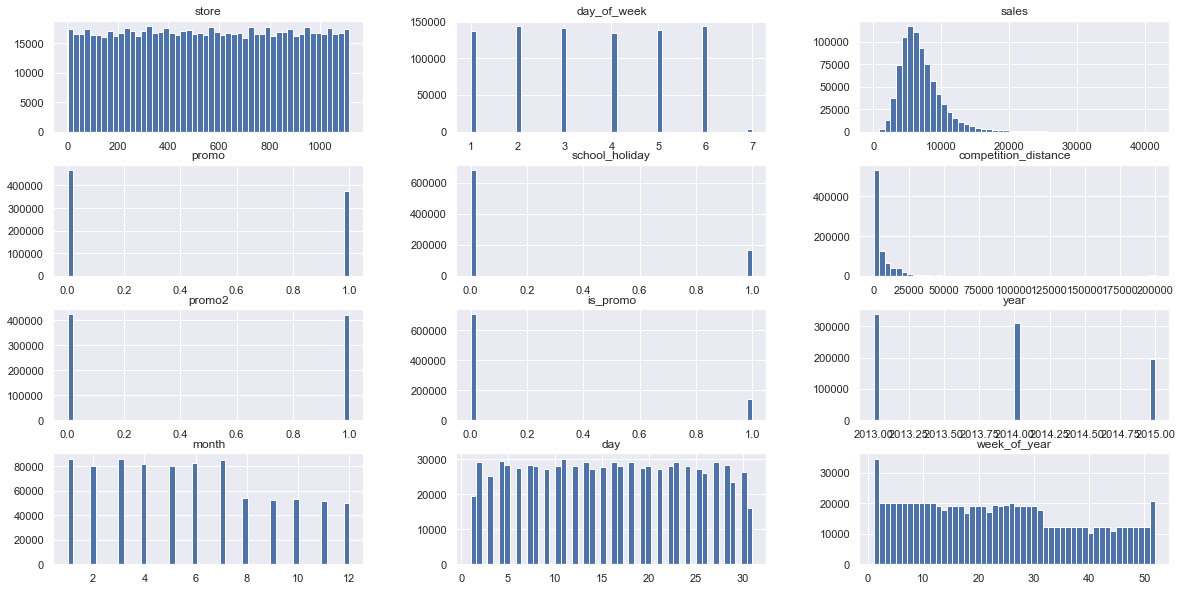

In [33]:
num_var.hist( bins = 50 );

### 4.1.3 Categoriacal Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

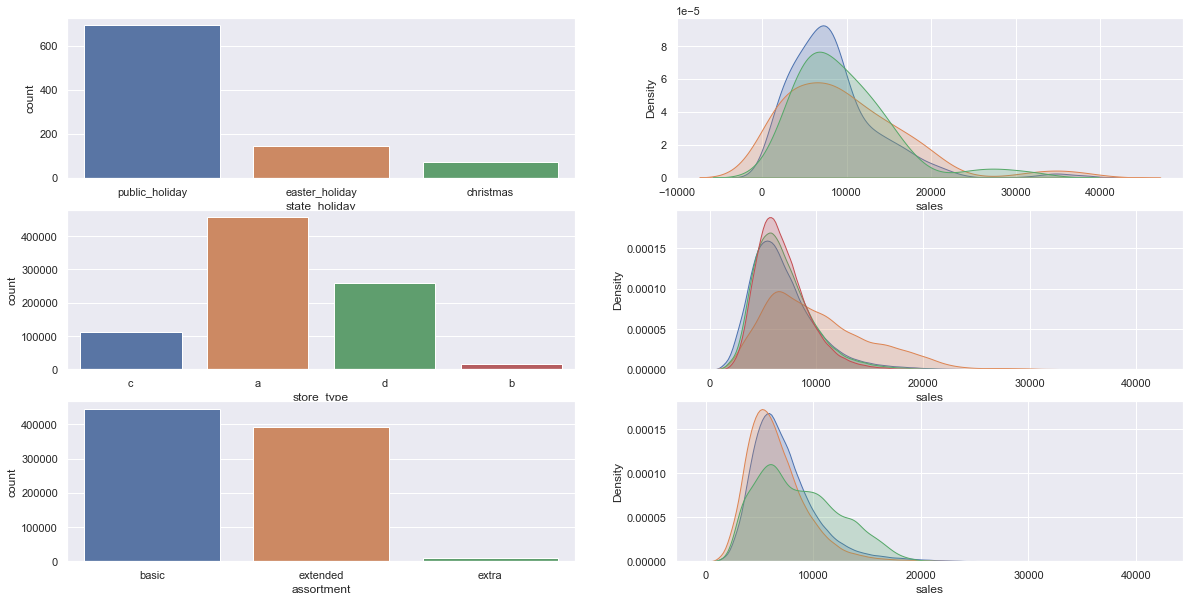

In [34]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( a[ 'state_holiday' ] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ] [ 'sales' ], label = 'public_holiday', shade = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ] [ 'sales' ], label = 'easter_holiday', shade = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ] [ 'sales' ], label = 'christmas', shade = True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4[ 'store_type' ] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ] [ 'sales' ], label = 'a', shade = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ] [ 'sales' ], label = 'b', shade = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ] [ 'sales' ], label = 'c', shade = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ] [ 'sales' ], label = 'd', shade = True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4[ 'assortment' ] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ] [ 'sales' ], label = 'extended', shade = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ] [ 'sales' ], label = 'basic', shade = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ] [ 'sales' ], label = 'extra', shade = True )

## 4.2 Bivariate Analysis - Hypothesis Tests

### H1 Stores with higher assortments should sell more.
#### False - Stores with less assortment sell more

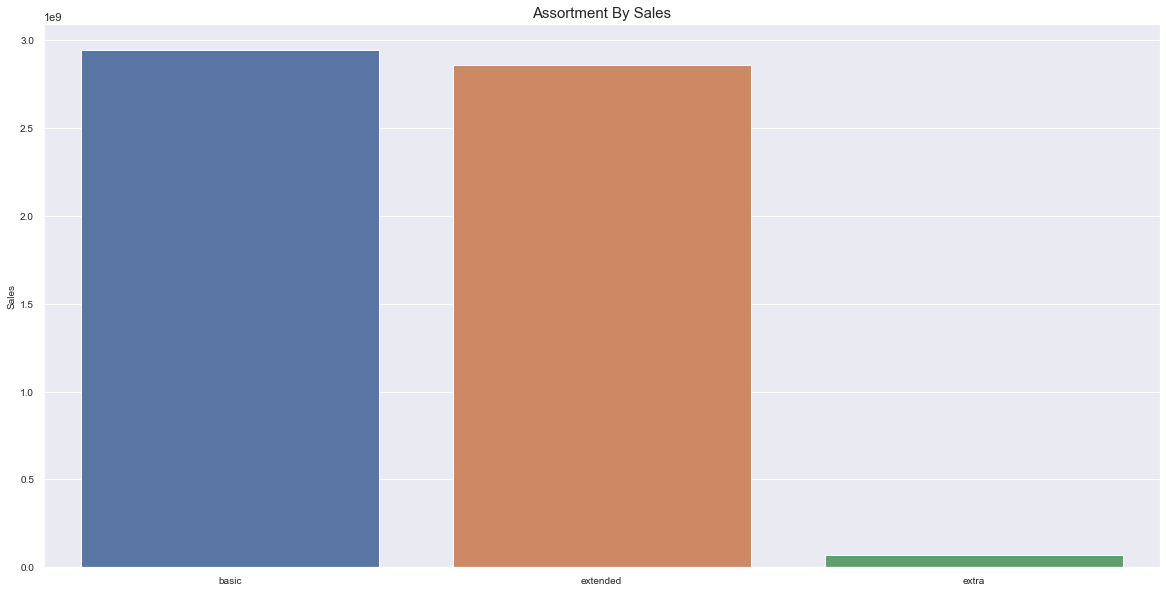

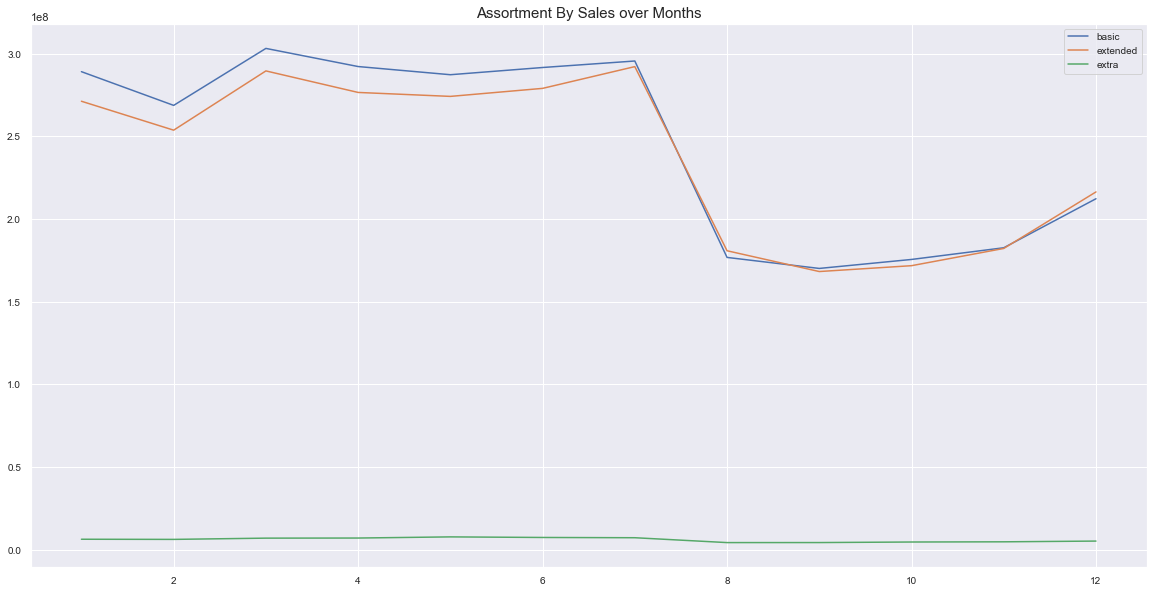

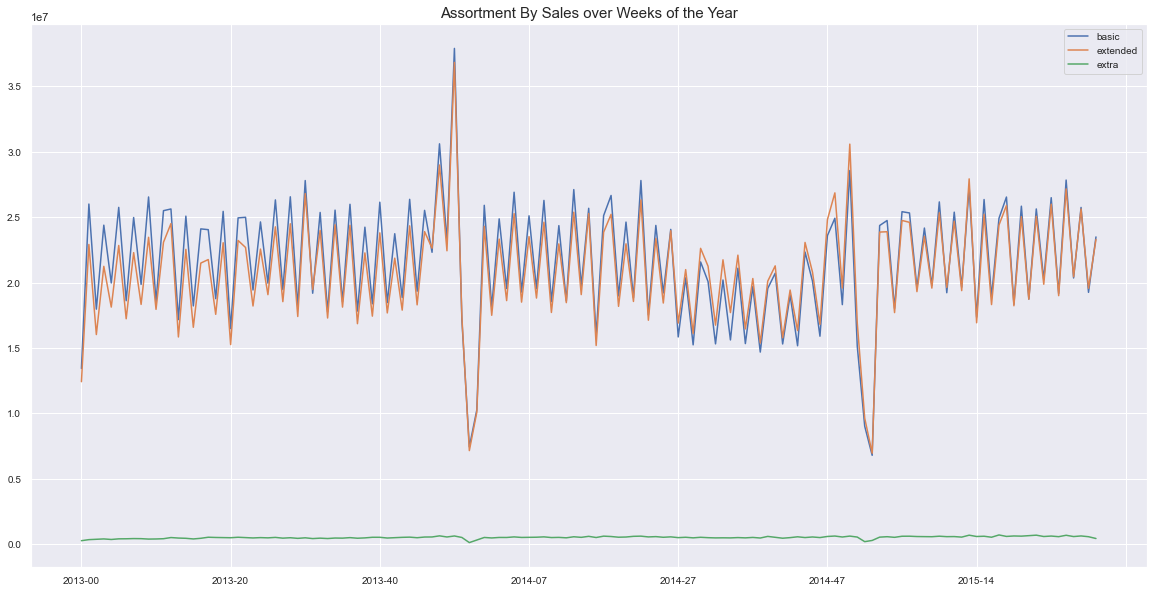

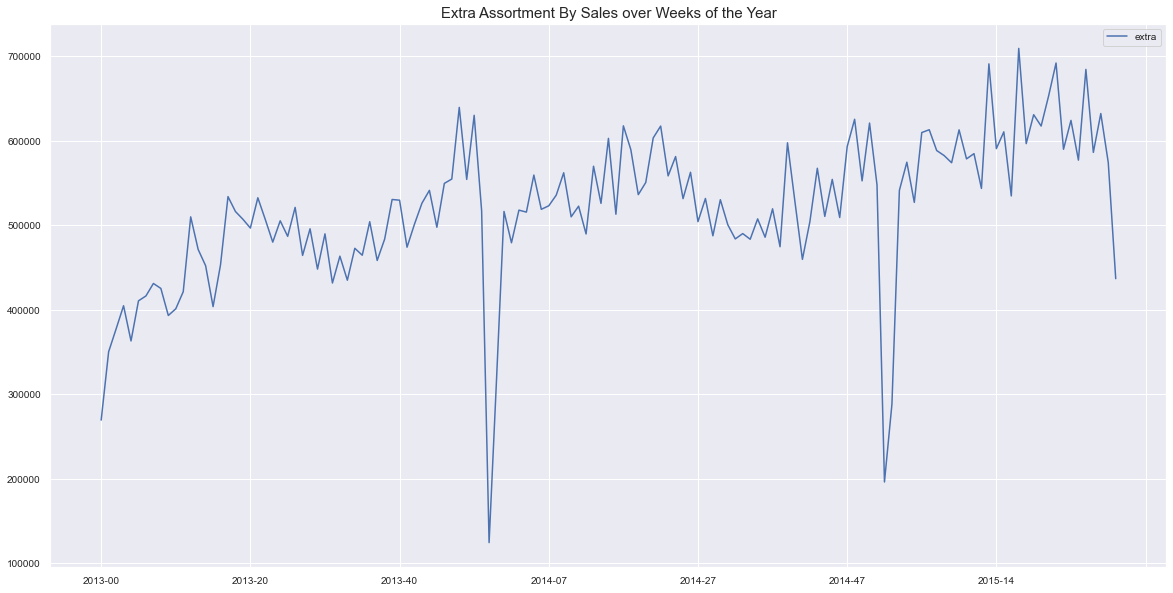

In [35]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y ='sales', data = aux1 );
plt.xlabel('');
plt.ylabel('Sales', size = 10);
plt.xticks(size=10)
plt.yticks(size=10)
plt.title('Assortment By Sales', size = 15);

aux2 = df4[['month', 'assortment', 'sales']].groupby( ['month','assortment'] ).sum().reset_index()
aux2.pivot( index='month', columns='assortment', values='sales' ).plot()
plt.legend(prop={"size":10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel("");
plt.title('Assortment By Sales over Months', size = 15);

aux3 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
plt.legend(prop={"size":10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel("");
plt.title('Assortment By Sales over Weeks of the Year', size = 15);

aux4 = aux3[aux3['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales' ).plot()
plt.legend(prop={"size":10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel("");
plt.title('Extra Assortment By Sales over Weeks of the Year', size = 15);

### H2 Stores with closer competitors should sell less
#### False - Stores with close competitors sell more


No handles with labels found to put in legend.


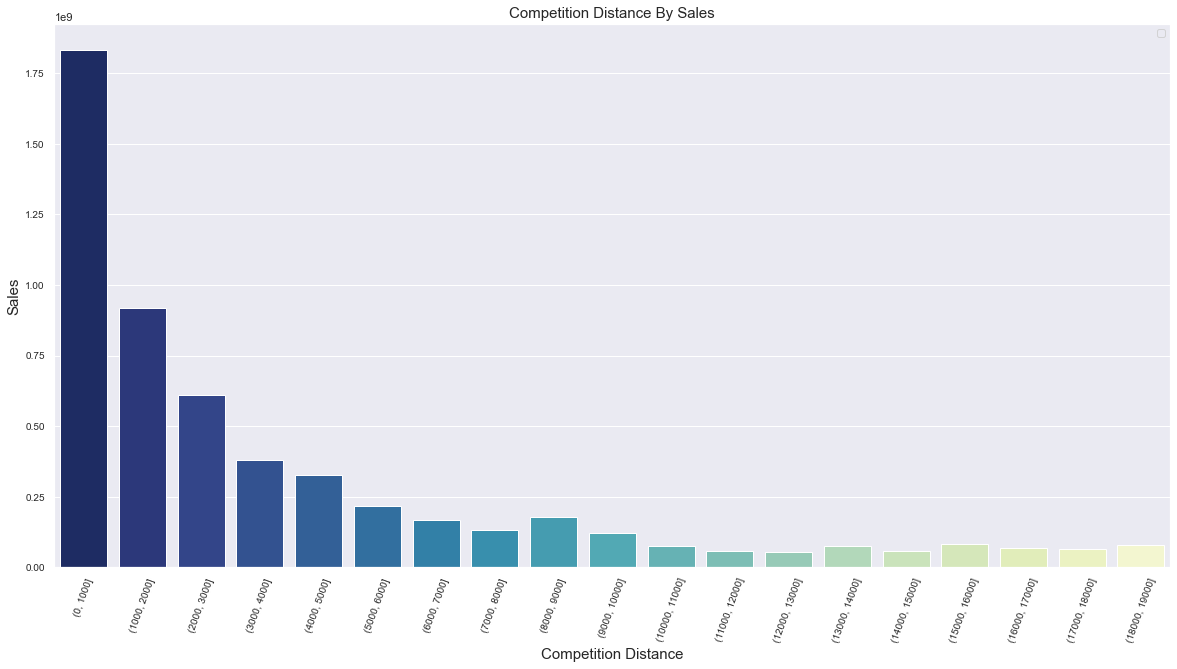

In [36]:
# plt.figure(figsize=(20, 12))
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2, palette = 'YlGnBu_r' );
plt.xticks( rotation=70 );
plt.legend(prop={"size":10});
plt.xticks(size=10);
plt.yticks(size=10);
plt.xlabel("Competition Distance", size = 15)
plt.ylabel("Sales", size = 15);
plt.title('Competition Distance By Sales', size = 15);
#plt.show();

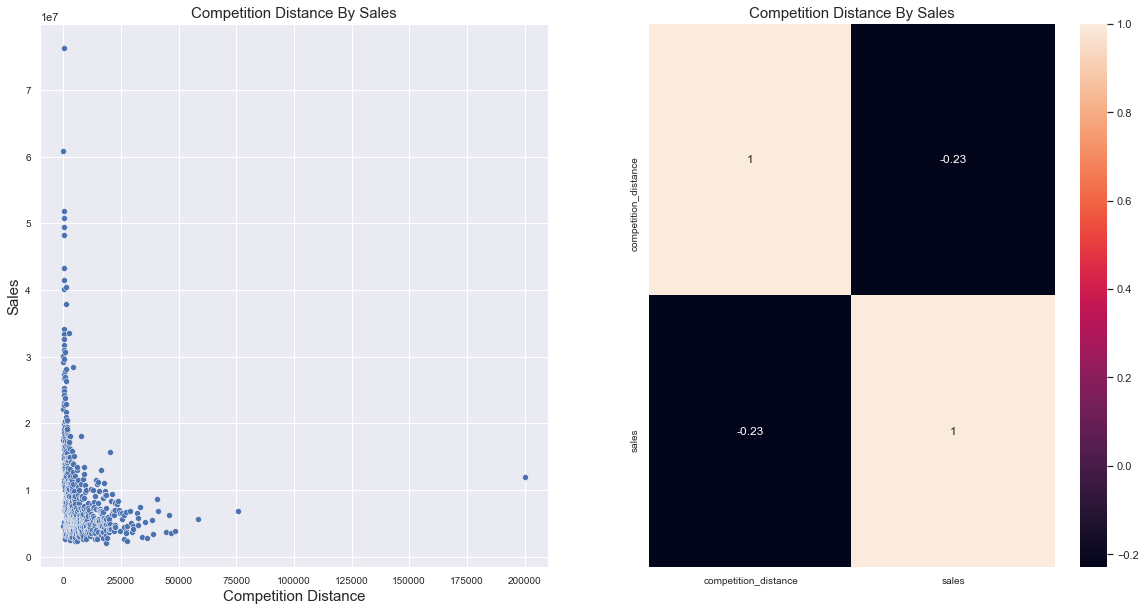

In [37]:
plt.subplot( 1, 2, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data = aux1);
plt.xticks(size=10);
plt.yticks(size=10);
plt.xlabel("Competition Distance", size = 15);
plt.ylabel("Sales", size = 15);
plt.title('Competition Distance By Sales', size = 15);

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.xticks(size=10);
plt.yticks(size=10);
plt.title('Competition Distance By Sales', size = 15);

### H3 Stores with long term competitors should sell more

#### False - Stores with short term competitors sell more

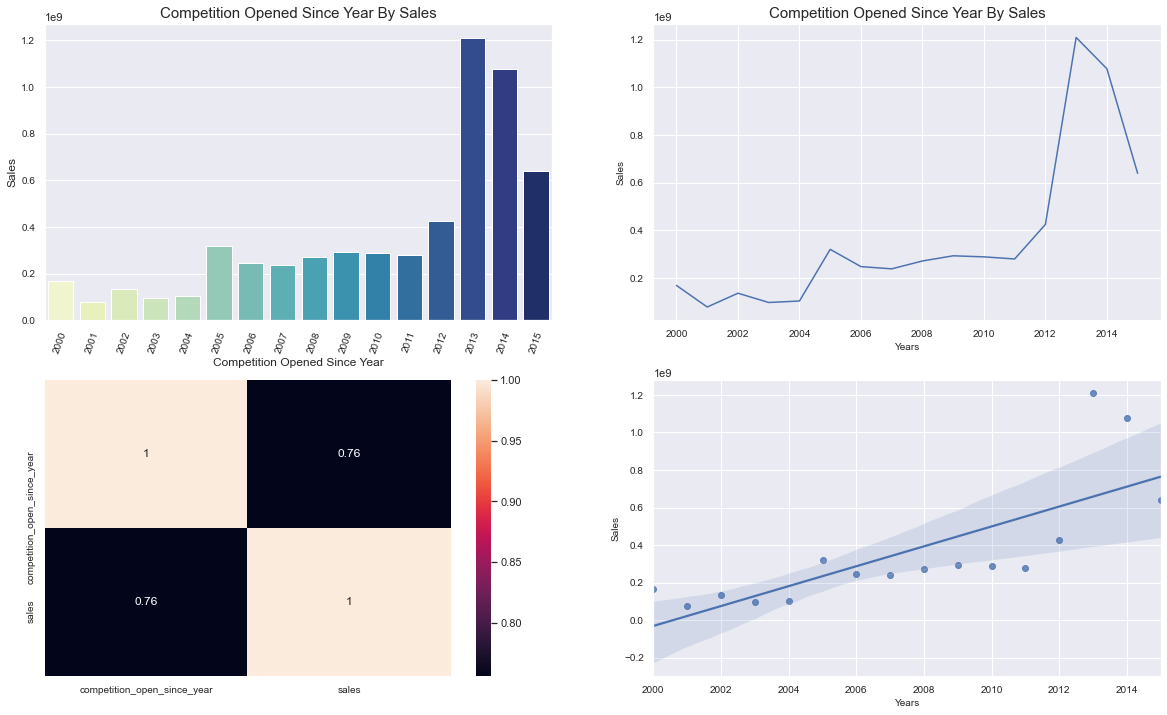

In [38]:
plt.figure(figsize=(20, 12), clear=True)
plt.subplot(2, 2, 1)
aux1 = df4[['competition_open_since_year', 'sales']].groupby('competition_open_since_year').sum().reset_index()
sns.barplot( x = 'competition_open_since_year', y = 'sales', data = aux1, palette = 'YlGnBu');
plt.xticks(size=10, rotation=70);
plt.yticks(size=10);
plt.xlabel("Competition Opened Since Year");
plt.ylabel("Sales");
plt.title('Competition Opened Since Year By Sales', size = 15);

plt.subplot(2, 2, 2)
sns.lineplot(data=aux1, x="competition_open_since_year", y="sales")
plt.title('Competition Opened Since Year By Sales', size = 15);
plt.xticks(size=10);
plt.yticks(size=10);
plt.xlabel('Years', size = 10);
plt.ylabel('Sales', size = 10);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method="pearson"), annot = True);
plt.xticks(size=10);
plt.yticks(size=10);


plt.subplot(2, 2, 4)
sns.regplot( x='competition_open_since_year', y='sales', data=aux1 );
plt.xticks(size=10);
plt.yticks(size=10);
plt.xlabel('Years', size = 10);
plt.ylabel('Sales', size = 10);
plt.show()

### H4 Stores with active promotions should sell more
#### True - Stores in promo 1 sell more
#### False - Stores in extended promo (promo 2) sell less

In [39]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
# Hypotesis Test
model = ols('sales ~ promo * promo2', data = df4).fit()
result = sm.stats.anova_lm(model)
result

,df,sum_sq,mean_sq,F,PR(>F)
promo,1.0,1.102741e+12,1.102741e+12,134954.951952,0.000000
promo2,1.0,1.321052e+11,1.321052e+11,16167.212555,0.000000
promo:promo2,1.0,1.479605e+07,1.479605e+07,1.810761,0.178417
Residual,844334.0,6.899204e+12,8.171178e+06,NaN,NaN


<AxesSubplot:xlabel='promo2', ylabel='sales'>

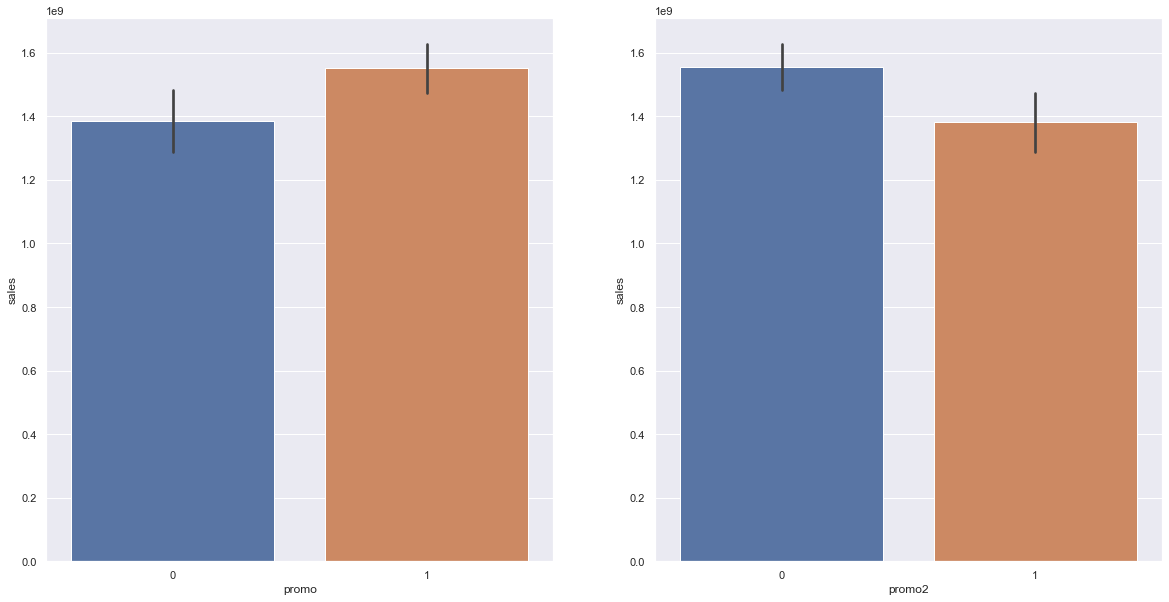

In [42]:
plt.subplot ( 1, 2, 1)
sns.barplot( data = aux1, x = 'promo', y = 'sales')

plt.subplot ( 1, 2, 2)
sns.barplot( data = aux1, x = 'promo2', y = 'sales')

### H5 Stores with more consecutive promotions sell more
#### False - Stores with more consecutive promotions seel less

In [43]:
aux = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()
aux

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


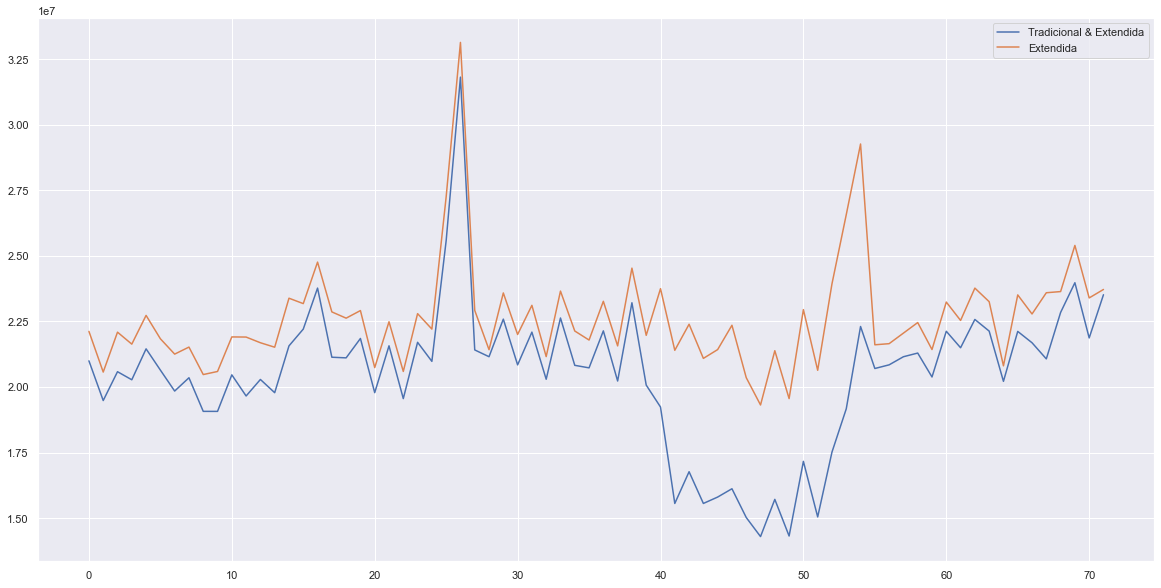

In [44]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H6 Stores open during the Christmas holiday should sell more.
#### False - Stores open during the Christmas holiday should sell less

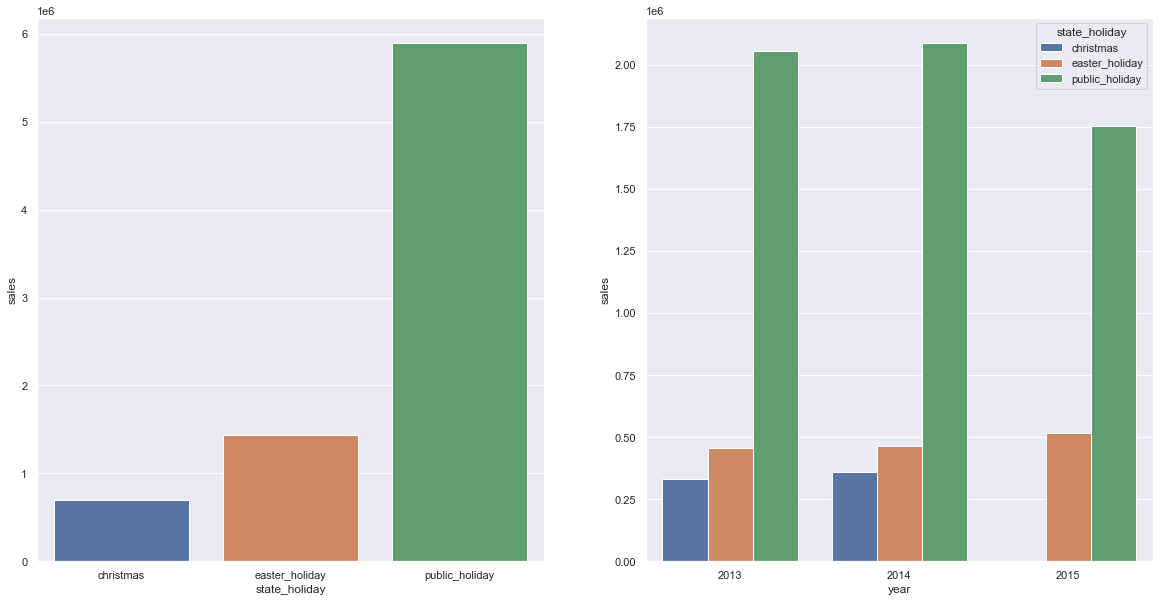

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H7 Stores should sell more over the years.
#### False - Stores sell less over the years

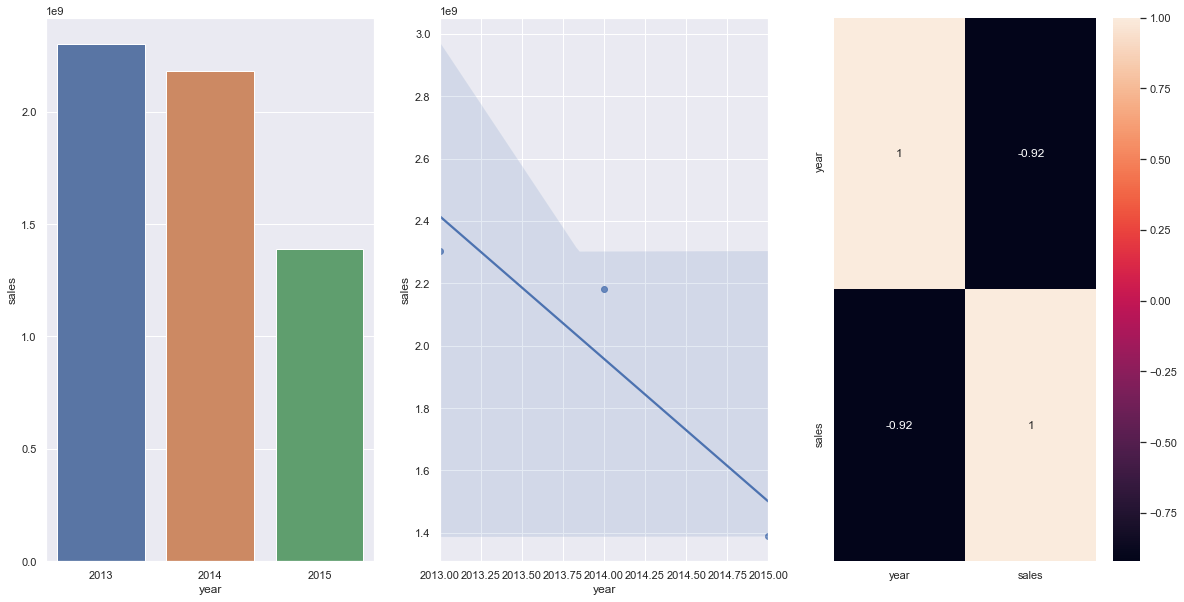

In [46]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H8 Stores should sell more in the second half of the year.
#### False - Stores sell less in the second half of the year

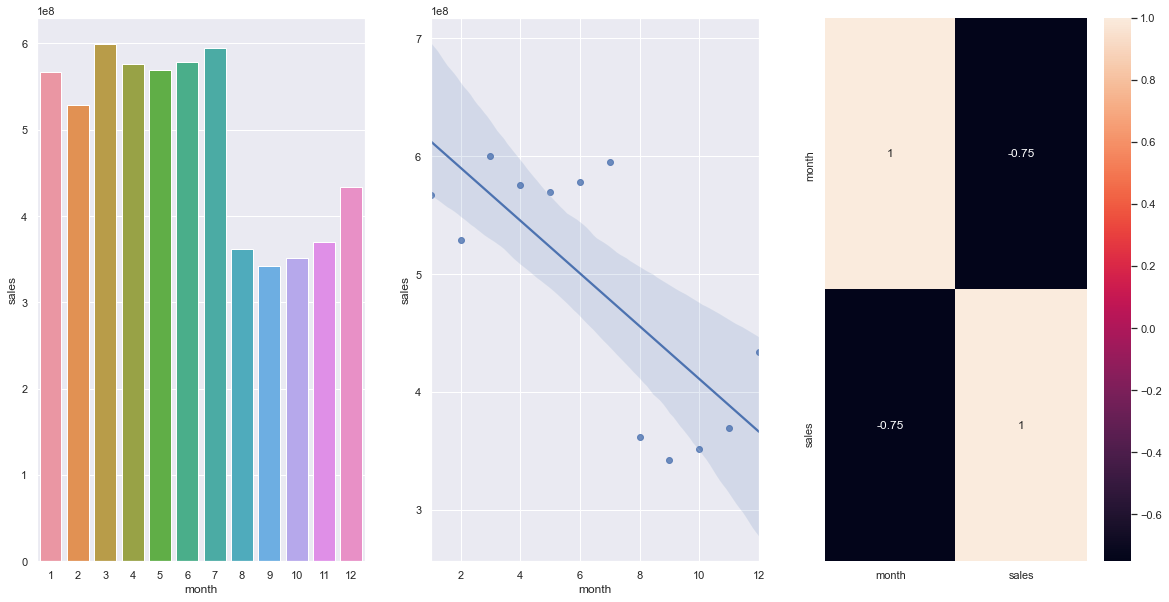

In [47]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9 Stores should sell less on weekends.
#### True - Stores sell less on weekends

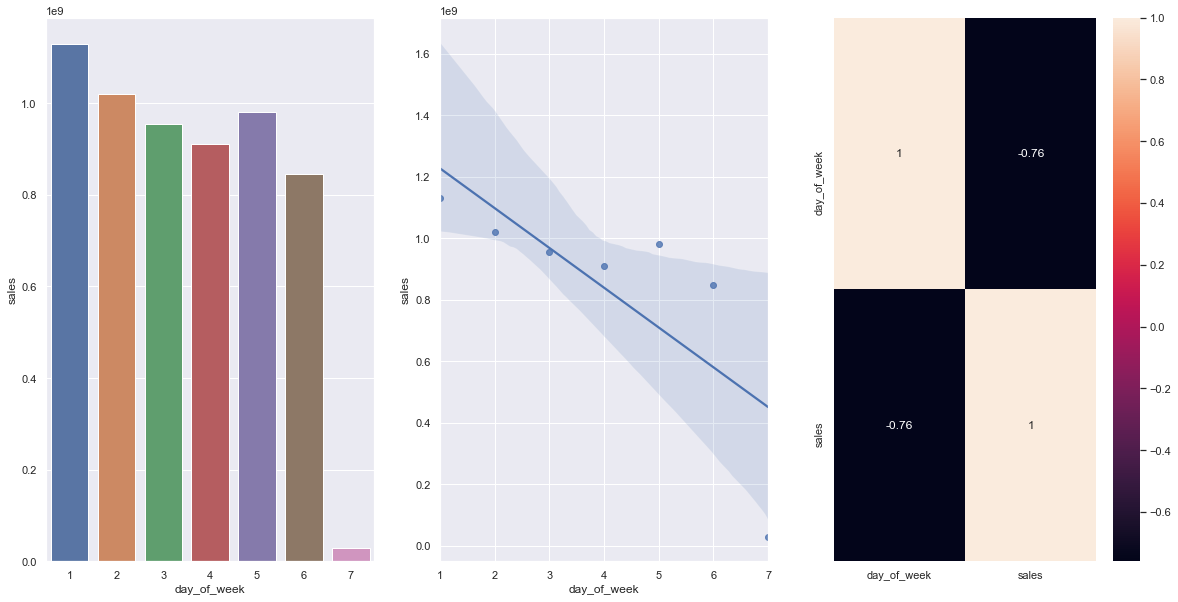

In [48]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10 Stores should sell less during school holidays.
#### True - Stores sell less during school holidays

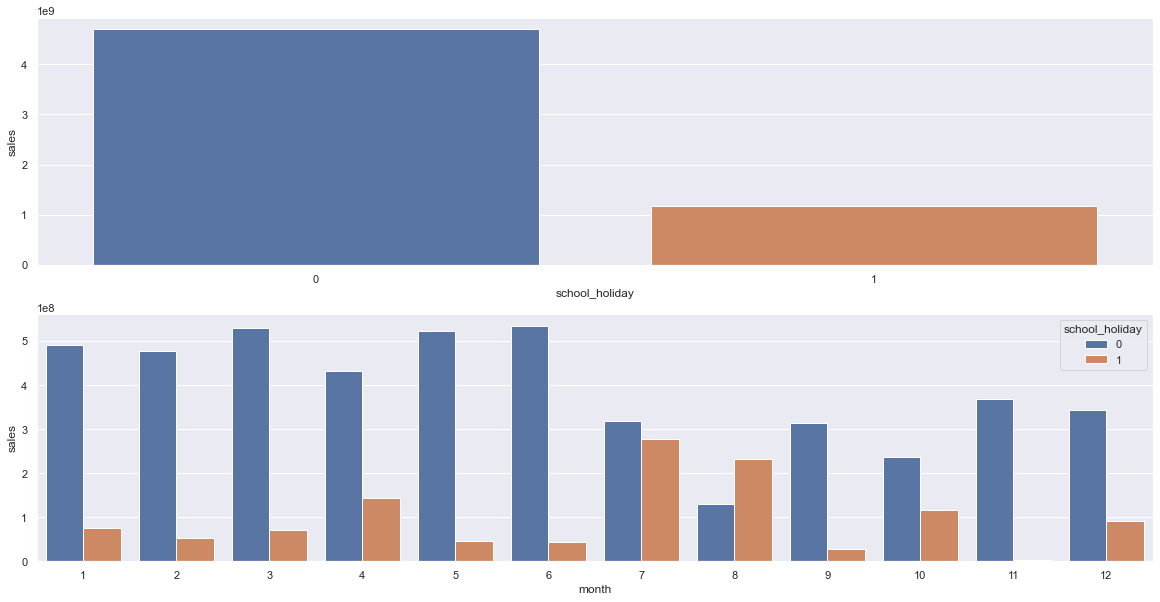

In [49]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Hypotesis Summary

#### H1 - False -> Conclusion - Stores with less assortment sell more

#### H2 - False -> Conclusion - Stores with close competitors sell more

#### H3 - False -> Conclusion - Stores with short term competitors sell more

#### H4 - False / True -> Conclusion - Stores in promo 1 sell more and stores in extended promo (promo 2) sell less

#### H5 - False -> Conclusion - Stores with more consecutive promotions seel less

#### H6 - False -> Conclusion - Stores open during the Christmas holiday sell less

#### H7 - False -> Conclusion - Stores sell less over the years

#### H8 - False -> Conclusion - Stores sell less in the second half of the year

#### H9 - True -> Conclusion - Stores sell less on weekends

#### H10 - True -> Conclusion - Stores sell less during school holidays

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attribites

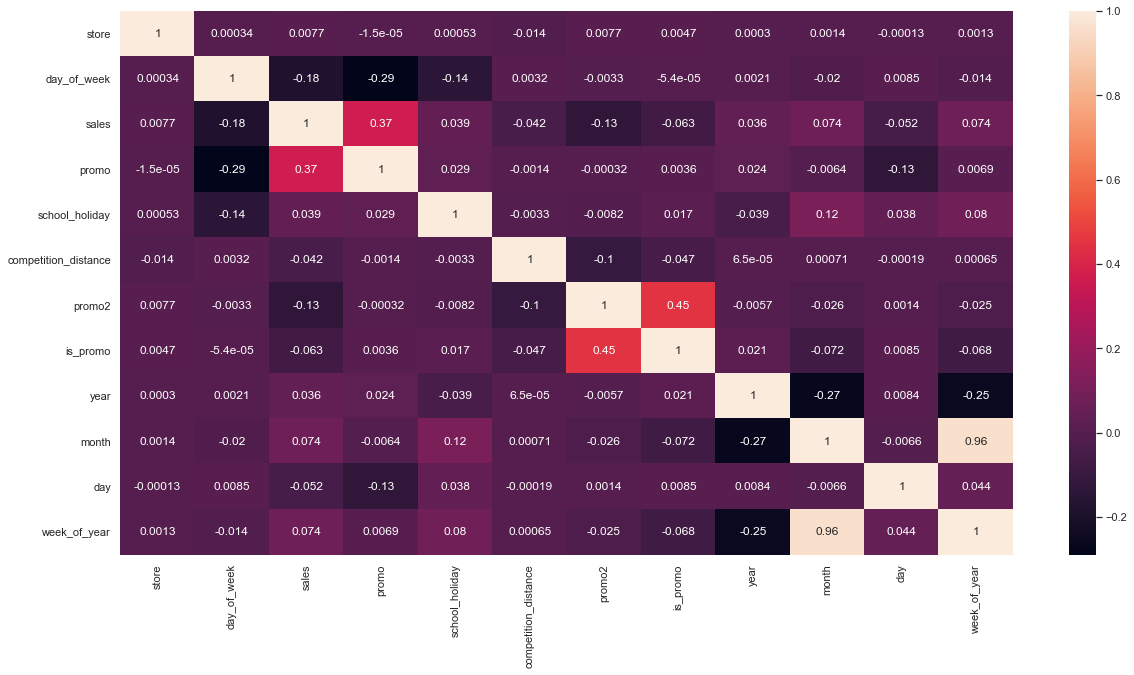

In [50]:
# All correlations
correl = num_var.corr( method = 'pearson' )
sns.heatmap( correl, annot = True );

In [51]:
# Only categorical variables
a = df4.select_dtypes( include = 'object' )
a.head().T

,0,1,2,3,4
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
year_week,2015-30,2015-30,2015-30,2015-30,2015-30


<AxesSubplot:>

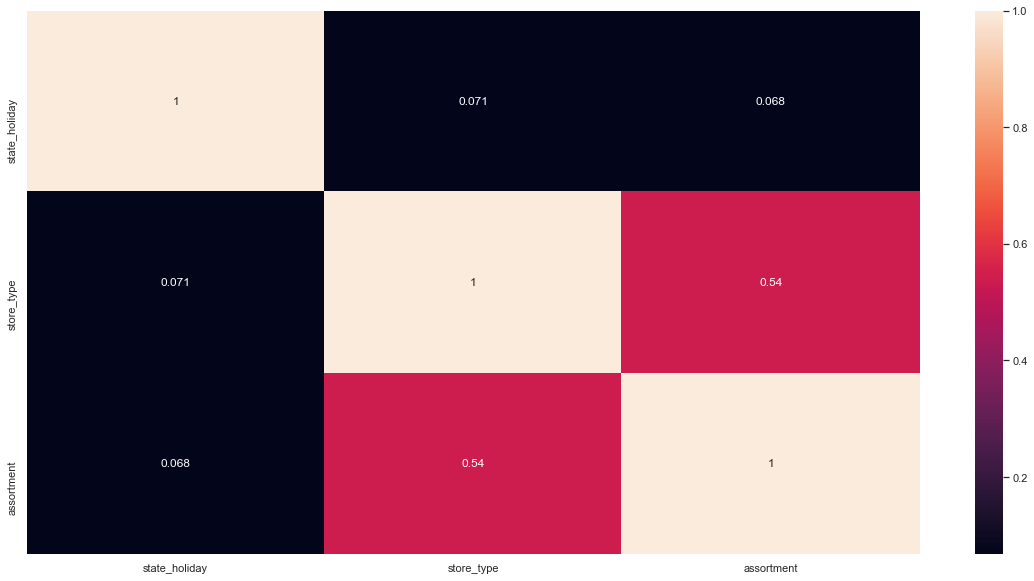

In [52]:
# Calculate Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [53]:
df5 = df4.copy()

## 5.1 Normalization
### No normalization required

## 5.2 Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

In [55]:
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Transform

### 5.3.1 Encoding

In [56]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [57]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.90323,-0.275806,4.44839
competition_open_since_month,9,11,12,9,4


### 5.3.2 Response Variable Transformation

In [58]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

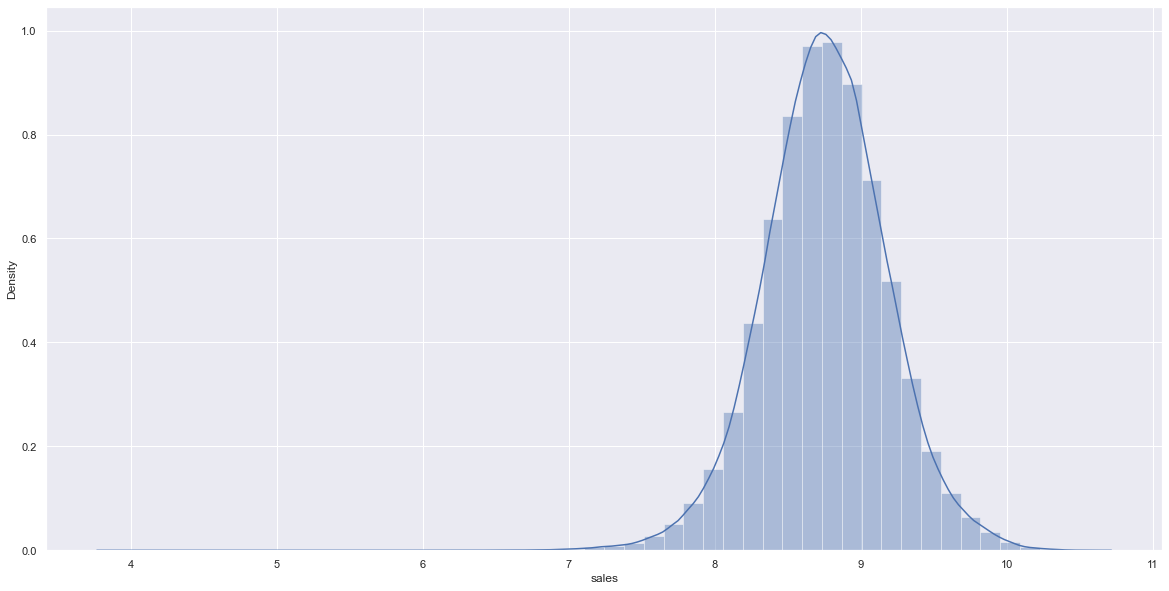

In [59]:
sns.distplot( df5 ['sales'] )

### 5.3.3 Nature Transformation

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [61]:
df6 = df5.copy()

In [62]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split dataframe into train and test

In [63]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ] 
df6 = df6.drop( cols_drop, axis = 1 )

In [64]:
df6[['store', 'date' ]].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [65]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [66]:
## Train and Test for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Boruta Features

In [67]:
#cols_selected = boruta.support_.tolist()
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Seceted Boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [68]:
#cols_selected_boruta

### 6.3 Manual Feature Selection

In [69]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modeling

In [70]:
# No inclsuion of sales and date yet
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [71]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )

# Estimation Baseline
yhat_baseline = aux1['predictions']

# Performance functions to calculate the perfomance to all future models
# We have transformed 'sales' with the log function, so we need to undo using exponencial function
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression

In [72]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( "Linear Regression", np.expm1( y_test ), np.expm1 (yhat_lr) ) 
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.673075,0.292552,2672.709592


### 7.2.1 Linear Regression Cross Validation

In [73]:
lr_result_cv = cross_validation( x_training, 5, "Linear Regression", lr, verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.34 +/- 294.41,0.3 +/- 0.02,2953.94 +/- 467.47


## 7.3 Linear Regression Regularized - LASSO

In [74]:
# Model
lrr = Lasso( alpha = 0.01).fit( x_train, y_train )

# Prediction
yhat_lrr = lr.predict( x_test )

# Performance
lrr_result = ml_error( "Linear Regression - Lasso", np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.591105,0.289458,2684.759506


### 7.3.1 Lasso Cross Validation

In [75]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose = False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2115.51 +/- 340.07,0.29 +/- 0.01,3057.0 +/- 503.1


## 7.4 Random Forest Regressor

In [76]:
# Model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict ( x_test )

# Performance
rf_result = ml_error( "Random Forest Regressor", np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.10212,0.099765,1009.427531


### 7.4.1 Random Forest Regressor Cross Validation

In [82]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose = True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.92 +/- 219.47,0.12 +/- 0.02,1257.95 +/- 320.7


## 7.5 XGBoost Regressor

In [78]:
# Model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 100,
                              eta = 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XBGoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XBGoost Regressor,6683.500534,0.949446,7330.784505


### 7.5.1 XGBoost Cross Validation

In [79]:
xgb_result_cv = cross_validation( x_training, 5, "XGBoost Regressor", model_xgb, verbose = True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.18 +/- 588.61,0.95 +/- 0.0,7715.16 +/- 689.49


## 7.6 Model's Performance Comparison

### 7.6.1 Single Performance

In [80]:
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.102120,0.099765,1009.427531
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.673075,0.292552,2672.709592
0,Linear Regression - Lasso,1867.591105,0.289458,2684.759506
0,XBGoost Regressor,6683.500534,0.949446,7330.784505


### 7.6.2 Real Performance - Cross Validation

In [83]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.92 +/- 219.47,0.12 +/- 0.02,1257.95 +/- 320.7
0,Linear Regression,2082.34 +/- 294.41,0.3 +/- 0.02,2953.94 +/- 467.47
0,Lasso,2115.51 +/- 340.07,0.29 +/- 0.01,3057.0 +/- 503.1
0,XGBoost Regressor,7049.18 +/- 588.61,0.95 +/- 0.0,7715.16 +/- 689.49


# 8.0 Hyperparamenter Fine Tuning

## 8.1 Random Search

In [84]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [85]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # Choose parameters values randomly
#    hp = { k: rnd.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # Model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # Performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

## 8.2 Tuned Parameters

In [87]:
param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'min_child_weight': 8 
        }

In [88]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,739.398063,0.110962,1059.709576
